In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-dataset/sample_submission.csv
/kaggle/input/football-dataset/X_test.csv
/kaggle/input/football-dataset/y_train.csv
/kaggle/input/football-dataset/X_train.csv


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the datasets
X_train = pd.read_csv('/kaggle/input/football-dataset/X_train.csv')
y_train = pd.read_csv('/kaggle/input/football-dataset/y_train.csv')['result']
X_test = pd.read_csv('/kaggle/input/football-dataset/X_test.csv')

# Preprocess the data
numeric_cols = ['neutral']
categorical_cols = ['home_team', 'away_team', 'tournament']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply transformations to X_train and X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=1000, seed=27, nthread=4)
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_xgb = xgb_model.predict(X_val)
validation_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print("Validation Accuracy for XGBoost model:", validation_accuracy_xgb)

# Make predictions on the test set using the XGBoost model
test_predictions_xgb = xgb_model.predict(X_test)
print("Test Accuracy : ",test_predictions_xgb)


Validation Accuracy for XGBoost model: 0.5583293326932309
Test Accuracy :  [2 2 2 ... 2 2 2]


In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the datasets
X_train = pd.read_csv('/kaggle/input/football-dataset/X_train.csv')
y_train = pd.read_csv('/kaggle/input/football-dataset/y_train.csv')['result']
X_test = pd.read_csv('/kaggle/input/football-dataset/X_test.csv')

# Preprocess the data
numeric_cols = ['neutral']
categorical_cols = ['home_team', 'away_team', 'tournament']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply transformations to X_train and X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

from sklearn.neural_network import MLPClassifier

# Train the neural network model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train.values.ravel())

# Make predictions on the validation set
y_val_pred_mlp = mlp_model.predict(X_val)
validation_accuracy_mlp = accuracy_score(y_val, y_val_pred_mlp)
print("Validation Accuracy for MLPClassifier model:", validation_accuracy_mlp)

# Make predictions on the test set using the MLPClassifier model
test_predictions_mlp = mlp_model.predict(X_test)


Validation Accuracy for MLPClassifier model: 0.5


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = pd.read_csv('/kaggle/input/football-dataset/X_train.csv')
y_train = pd.read_csv('/kaggle/input/football-dataset/y_train.csv')['result']
X_test = pd.read_csv('/kaggle/input/football-dataset/X_test.csv')

train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)

train_data.drop(['date', 'tournament', 'city', 'country'], axis=1, inplace=True)
X_test.drop(['date', 'tournament', 'city', 'country'], axis=1, inplace=True)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_train = pd.DataFrame(encoder.fit_transform(train_data[['home_team', 'away_team']]))
encoded_test = pd.DataFrame(encoder.transform(X_test[['home_team', 'away_team']]))

train_data = pd.concat([train_data, encoded_train], axis=1)
X_test = pd.concat([X_test, encoded_test], axis=1)

train_data.drop(['home_team', 'away_team'], axis=1, inplace=True)
X_test.drop(['home_team', 'away_team'], axis=1, inplace=True)

train_data.columns = train_data.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Logistic Regression
lrm = LogisticRegression(max_iter=1000, random_state=42)

X = train_data.drop('result', axis=1)
y = train_data['result']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lrm.fit(X_train, y_train)

y_pred = lrm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: ", accuracy)

prediction = lrm.predict(X_test)

output = pd.DataFrame({
    'row_id': range(len(prediction)),
    'result': prediction
})


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy:  0.5700912145943351


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train = pd.read_csv('/kaggle/input/football-dataset/X_train.csv')
y_train = pd.read_csv('/kaggle/input/football-dataset/y_train.csv')['result']
X_test = pd.read_csv('/kaggle/input/football-dataset/X_test.csv')

train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)

train_data.drop(['date', 'tournament', 'city', 'country'], axis=1, inplace=True)
X_test.drop(['date', 'tournament', 'city', 'country'], axis=1, inplace=True)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_train = pd.DataFrame(encoder.fit_transform(train_data[['home_team', 'away_team']]))
encoded_test = pd.DataFrame(encoder.transform(X_test[['home_team', 'away_team']]))

train_data = pd.concat([train_data, encoded_train], axis=1)
X_test = pd.concat([X_test, encoded_test], axis=1)

train_data.drop(['home_team', 'away_team'], axis=1, inplace=True)
X_test.drop(['home_team', 'away_team'], axis=1, inplace=True)

train_data.columns = train_data.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

X = train_data.drop('result', axis=1)
y = train_data['result']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: ", accuracy)

prediction = rfc.predict(X_test)

output = pd.DataFrame({
    'row_id': range(len(prediction)),
    'result': prediction
})

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy:  0.5178828612578013


In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the datasets
X_train = pd.read_csv('/kaggle/input/football-dataset/X_train.csv')
y_train = pd.read_csv('/kaggle/input/football-dataset/y_train.csv')['result']
X_test = pd.read_csv('/kaggle/input/football-dataset/X_test.csv')

# Preprocess the data
numeric_cols = ['neutral']
categorical_cols = ['home_team', 'away_team', 'tournament']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply transformations to X_train and X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=1000, seed=27, nthread=4)

# Number of epochs
num_epochs = 10

# Initialize a list to store validation accuracies for each epoch
validation_accuracies = []

# Train the XGBoost model for multiple epochs
for epoch in range(num_epochs):
    # Train the XGBoost model for one epoch
    xgb_model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_val_pred_xgb = xgb_model.predict(X_val)
    
    # Compute the validation accuracy for this epoch
    validation_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
    validation_accuracies.append(validation_accuracy_xgb)
    
    # Print the validation accuracy after every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}: Validation Accuracy = {validation_accuracy_xgb}")

# Make predictions on the test set using the XGBoost model
test_predictions_xgb = xgb_model.predict(X_test)


Epoch 5: Validation Accuracy = 0.5583293326932309
Epoch 10: Validation Accuracy = 0.5583293326932309


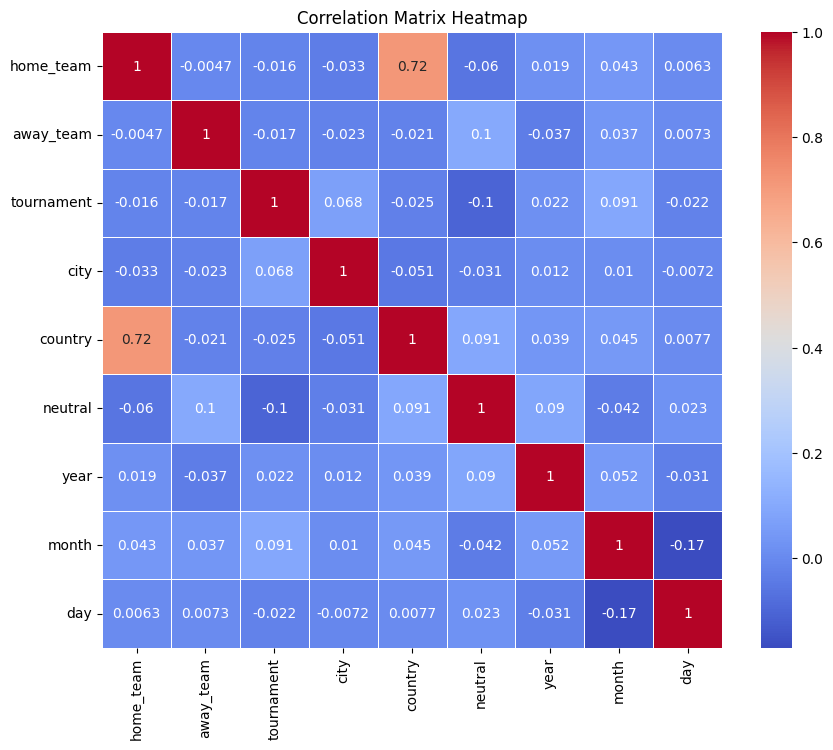

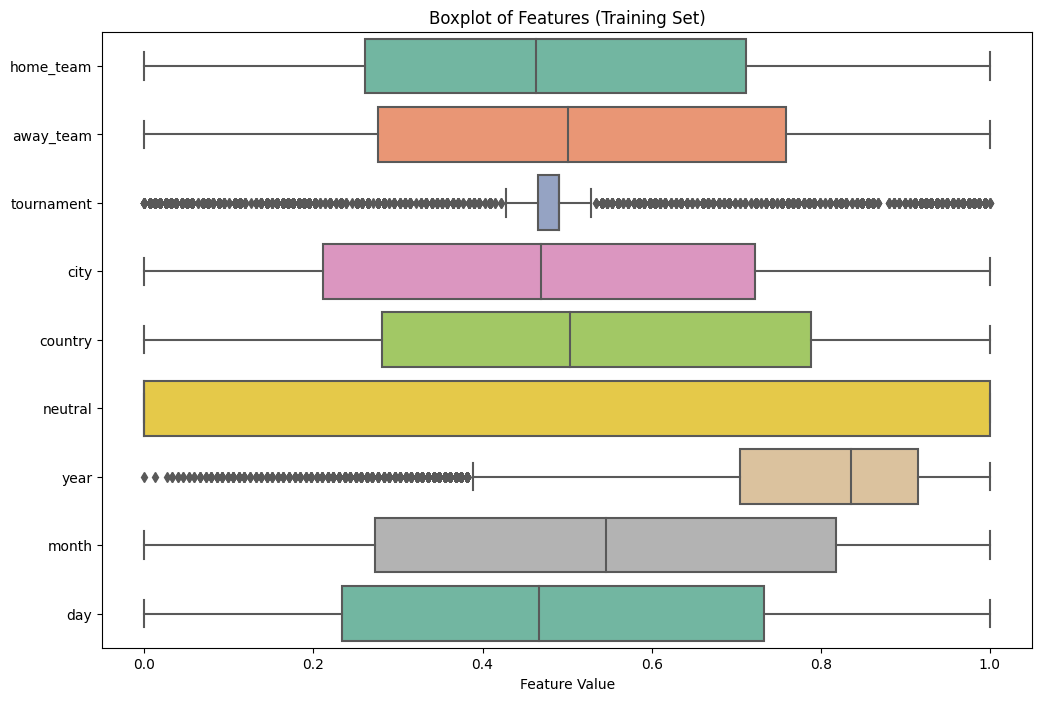

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_train = pd.read_csv('/kaggle/input/football-dataset/X_train.csv')
y_train = pd.read_csv('/kaggle/input/football-dataset/y_train.csv')['result']
X_test = pd.read_csv('/kaggle/input/football-dataset/X_test.csv')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['home_team','away_team','tournament','city','country']
boolean_columns = ['neutral']

for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.fit_transform(X_test[col])
for col in boolean_columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])
for df in [X_train, X_test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # Convert year, month, and day columns to integer type
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    df['day'] = df['day'].astype(int)
    
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

X_train.drop(columns = ['date'],inplace = True)
X_test.drop(columns = ['date'],inplace = True)

from sklearn.model_selection import train_test_split
X_train,X_val ,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_val_df = pd.DataFrame(X_val, columns=X_val.columns)

from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_val = minmax_scaler.transform(X_val)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_val_df = pd.DataFrame(X_val, columns=X_val_df.columns)

corr_matrix = X_train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=X_train_df, orient='h', palette='Set2')
plt.title('Boxplot of Features (Training Set)')
plt.xlabel('Feature Value')
plt.show()

In [8]:
#linear kernel and changing c value only as gamma,degree have no effect on it
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC(kernel = 'linear')

svc.fit(X_train,y_train)
y_pred = svc.predict(X_val)
print("Accuracy score of the validation data : " , accuracy_score(y_val,y_pred))

Accuracy score of the validation data :  0.485357657225156


In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_val)

print("The accuracy score : ", accuracy_score(y_val,y_pred))
print("The classification report : ", classification_report(y_val,y_pred))
print("The confusion matrix : ", confusion_matrix(y_val,y_pred))

The accuracy score :  0.4842774843975036
The classification report :                precision    recall  f1-score   support

           0       0.00      0.00      0.00      1967
           1       0.36      0.07      0.12      2321
           2       0.49      0.96      0.65      4044

    accuracy                           0.48      8332
   macro avg       0.28      0.34      0.26      8332
weighted avg       0.34      0.48      0.35      8332

The confusion matrix :  [[   0  115 1852]
 [   0  162 2159]
 [   0  171 3873]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
